In [1]:
import math
import torch
import pandas as pd
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import morethemes as mt
import numpy as np
import morethemes as mt

In [4]:
df = pd.read_pickle("/workspaces/ds_project_1/data/dataset.pkl")

In [13]:
df.head()

,prices,load_fcst,cos_day,sin_day,prev_day_prices,prev_48_prices,prev_week_prices,prev_day_last_price,solar,wind_on,prev_day_load,prev_day_solar,prev_day_wind_on,prev_week_load,prev_week_solar,prev_week_wind_on
2018-01-08 00:00:00+01:00,18.91,59650.0,0.62349,0.781831,21.87,29.45,6.74,27.01,0.0,5995.0,61650.0,0.0,4438.0,56250.0,0.0,10113.0
2018-01-08 01:00:00+01:00,15.15,57050.0,0.62349,0.781831,15.98,28.55,4.74,27.01,0.0,5638.0,58150.0,0.0,5020.0,54300.0,0.0,10042.0
2018-01-08 02:00:00+01:00,15.11,56200.0,0.62349,0.781831,15.99,28.18,3.66,27.01,0.0,5391.0,56550.0,0.0,5613.0,53600.0,0.0,9627.0
2018-01-08 03:00:00+01:00,13.42,53300.0,0.62349,0.781831,14.00,25.27,1.26,27.01,0.0,5145.0,52900.0,0.0,6206.0,50000.0,0.0,9200.0
2018-01-08 04:00:00+01:00,12.91,51950.0,0.62349,0.781831,12.51,24.34,-20.10,27.01,0.0,4906.0,50950.0,0.0,6798.0,47100.0,0.0,8771.0


In [24]:
df.shape

(61176, 16)

In [12]:
prices = df["prices"].values[:int(len(df.values)*0.7)]

In [20]:
prices = df["prices"].values
predictors = df.drop(columns=["prices"])

In [13]:
prices.shape

(42823,)

In [11]:
prices

np.float64(138.66)

In [ ]:
predictors = predictors.values

In [23]:
print(predictors.shape)

(61176, 15)


In [25]:
predictors[15]

array([6.89500000e+04, 6.23489802e-01, 7.81831482e-01, 1.98600000e+01,
       3.74000000e+01, 8.56000000e+00, 2.70100000e+01, 1.01800000e+03,
       2.68500000e+03, 5.76000000e+04, 9.64000000e+02, 8.73300000e+03,
       5.09500000e+04, 9.51000000e+02, 9.49000000e+03])

In [4]:
class RNNfromscratch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout

        self.W_xh = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size))
        self.W_hh = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.b_h = nn.Parameter(torch.Tensor(self.hidden_size))

        if self.num_layers > 1:
            self.W_layers = nn.ParameterList([nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size)) for _ in range(self.num_layers-1)])
            self.U_layers = nn.ParameterList([nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size)) for _ in range(self.num_layers-1)])
            self.b_layers = nn.ParameterList([nn.Parameter(torch.Tensor(self.hidden_size)) for _ in range(self.num_layers-1)])

        self.dropout = nn.Dropout(self.dropout_prob)
        self.reset_parameters()
    
    def reset_parameters(self):
        """
        Function called by Pytorch framework to init parameters.
        """
        nn.init.xavier_normal_(self.W_xh) # For input-to-hidden with corrected variance
        nn.init.orthogonal_(self.W_hh) # for recurrent weights
        nn.init.zeros_(self.b_h)
        
        if self.num_layers > 1:
            for i in range(self.num_layers - 1):
                nn.init.xavier_uniform_(self.W_layers[i])
                nn.init.orthogonal_(self.U_layers[i])
                nn.init.zeros_(self.b_layers[i])

    
    def forward(self, X, state=None):
        # X.shape = (seq_len, batch_size, input size)
        seq_len, batch_size, _ = X.shape

        if state is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=X.device)
        else:
            # Clone to avoid inplace operations which can cause errors during backprop
            hidden = state.clone()

        outputs = torch.zeros(seq_len, batch_size, self.hidden_size, device=X.device)

        for t in range(seq_len):
            new_hidden = torch.zeros_like(hidden)
            x_t = X[t]
            for layer in range(self.num_layers):
                if layer==0:
                    h_state = torch.tanh(x_t @ self.W_xh + hidden[layer] @ self.W_hh + self.b_h)
                else:
                    h_state = torch.tanh(hidden[layer] @ self.U_layers[layer-1] + hidden[layer-1] @ self.W_layers[layer-1] + self.b_layers[layer-1])

                if layer < self.num_layers-1 or t < seq_len-1:
                    h_state = self.dropout(h_state)

                new_hidden[layer] = h_state
            # print(f"For time step {t} hidden state shape: {len(hidden)}")
            hidden = new_hidden.clone()
            outputs[t] = hidden[-1]

        return outputs, new_hidden

In [10]:
class MultiStepRNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, output_steps=1, num_layers=1, dropout=0.2):
        super().__init__()
        self.output_steps = output_steps
        
        # RNN de base sans modifications
        self.rnn = RNNfromscratch(input_size, hidden_size, num_layers, dropout)
        
        # Projection simple pour chaque pas de temps à prédire
        self.projections = nn.ModuleList([
            nn.Linear(hidden_size, output_size) for _ in range(output_steps)
        ])
        
        # Normalisation de couche pour stabiliser l'apprentissage
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, X):
        """
        X: tenseur de forme (batch_size, seq_len, input_size)
        """
        # Permuter pour (seq_len, batch_size, input_size)
        X = X.permute(1, 0, 2)
        
        # Passer à travers le RNN
        _, final_hidden = self.rnn(X)
        
        # Utiliser uniquement l'état caché final de la dernière couche
        final_hidden_flat = final_hidden[-1]
        final_hidden_norm = self.layer_norm(final_hidden_flat)
        
        # Prédictions pour chaque pas de temps futur
        predictions = []
        for projection in self.projections:
            pred = projection(final_hidden_norm)
            predictions.append(pred)
            
        # Stack pour former un tenseur (batch_size, output_steps, output_size)
        if self.output_steps > 1:
            return torch.stack(predictions, dim=1)
        else:
            return predictions[0]  # Retourne simplement le tenseur pour un pas

In [ ]:
class RNNForecasting(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size, forecast_steps):
        super().__init__()
        self.output_size = output_size
        self.forecast_steps = forecast_steps
        self.rnn = RNNfromscratch(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.output_layers = nn.ModuleList(nn.Linear(hidden_size, output_size) for _ in range(forecast_steps))
        # Normalisation de couche pour stabiliser l'apprentissage
        self.layer_norm = nn.LayerNorm(hidden_size)
    
    def forward(self, X):
        X = X.permute(1, 0, 2)
        _, hidden = self.rnn(X)
        
        predictions = []
        for layer in self.output_layers:
            predictions.append(layer(self.layer_norm(hidden[-1])))
        
        if self.forecast_steps>1:
            return torch.stack(predictions, dim=1)
        else:
            return predictions[0]
        

In [6]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, preds, target):
        return torch.sqrt(self.mse(preds, target))

In [7]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, seq_length, forecasting_steps, flag:str, normalize:bool=True):
        super().__init__()
        self.seq_length = seq_length
        self.forecasting_steps = forecasting_steps
        flag_map = {"train": 0, "val": 1, "test": 2}
        self.flag = flag_map[flag]
        self.normalize = normalize
        self.scalers = {}
        self._load_data()
    
    def _load_data(self):
        df = pd.read_pickle("/workspaces/ds_project_1/data/dataset.pkl")

        data_len = len(df.values) - self.seq_length + self.forecasting_steps + 1

        self.subset_map = {0: 0.7, 1: 0.85, 2: 1}
        if self.flag==0:
            borders = [0, int(np.ceil(data_len*0.7))]
        else:
            train_borders, borders = self._get_splits_border(data_len=data_len)


        if self.normalize:
            self.scalers["predictors"] = StandardScaler()
            self.scalers["target"] = StandardScaler()

            if self.flag==0:
                self.target = df["prices"].values[borders[0]:borders[1]]
                df = df.drop(columns=["prices"])
                self.predictors = df.values[borders[0]:borders[1]]

                self.predictors = self.scalers["predictors"].fit_transform(self.predictors)
                self.target =  self.scalers["target"].fit_transform(self.target.reshape(-1, 1))
            else:
                self.target = df["prices"].values[borders[0]:borders[1]]
                self.scalers["target"].fit(df["prices"].values[train_borders[0]:train_borders[1]].reshape(-1, 1))
                self.target = self.scalers["target"].transform(self.target.reshape(-1, 1))

                df = df.drop(columns=["prices"])
                self.predictors = df.values[borders[0]:borders[1]]

                self.scalers["predictors"].fit(df.values[train_borders[0]:train_borders[1]])
                print(f"predictors shape: {self.predictors.shape}")
                self.predictors = self.scalers["predictors"].transform(self.predictors)

        else:
            self.target = df["prices"].values[borders[0]:borders[1]]
            df = df.drop(columns=["prices"])
            self.predictors = df.values[borders[0]:borders[1]]

    def _get_splits_border(self, data_len):
        
        train_borders = [0, int(np.ceil(data_len*0.7))]
        borders = [int(np.ceil(data_len*self.subset_map[self.flag-1])), int(np.ceil(data_len*self.subset_map[self.flag]))]
        return train_borders, borders

    def __getitem__(self, index):
        preds = self.predictors[index:index+self.seq_length]
        target = self.target[index+self.seq_length+self.forecasting_steps] if self.forecasting_steps>1 else self.target[index+self.seq_length]
        return torch.tensor(preds, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.predictors) - self.seq_length
    
    def inverse_transform_target(self, data):
        """Inverse la normalisation pour les valeurs prédites"""
        if self.normalize:
            return self.scalers['target'].inverse_transform(data.reshape(-1, 1)).flatten()
        return data

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=True, path:str="checkpoint.pt"):
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.best_score = None
        self.counter = 0
        self.val_loss_min = float('inf')
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        "Dunder methods to use a class instance as a function"
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, val_loss)

        elif score < self.best_score:

            self.counter += 1
            if self.verbose:
                print(f"Validation loss decreased: {self.counter} out of {self.patience} epochs")
            if self.counter==self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, val_loss)
            self.counter = 0

    
    def save_checkpoint(self, model, val_loss):
        if self.verbose:
            print(f"Validation metric decreased: {self.val_loss_min: .6f} ----> {val_loss}")
        # .state_dict(): Return a dictionary containing references to the whole state of the module.
        torch.save(obj=model.state_dict(), f=self.path)
        self.val_loss_min = val_loss


In [8]:
from tqdm import tqdm
import time
import numpy as np

def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_func, num_epochs, patience, verbose=True):

    # Init early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        epoch_loss = 0.0
        model.train()

        epoch_time = time.time()

        for i, (batch_x, batch_y) in enumerate(tqdm(train_loader, desc=f"epoch{epoch+1}/{num_epochs}", unit="batch")):
            # batch_x = batch_x.to_device(device)
            # batch_y = batch_y.to_device(device)
            optimizer.zero_grad()

            pred = model(batch_x)
            loss = loss_func(pred, batch_y)

            # backprop
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss/len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(val_loader):
                pred = model(batch_x)
                loss = loss_func(pred, batch_y)
                val_loss += loss.item()

        avg_val_loss = val_loss/len(val_loader)
        val_losses.append(avg_val_loss)

        # Early stopping check
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if verbose:
            print(f"Epoch: {epoch + 1}/{num_epochs} | Cost time: {time.time() - epoch_time}")
            print(f"Train Loss: {avg_train_loss} | Validation Loss: {avg_val_loss}")
    # Load best model:
    model.load_state_dict(torch.load(early_stopping.path))
    
    return model, train_losses, val_losses



In [10]:
def evaluate_model(model, test_loader, loss_func, dataset):
    test_loss = 0.0
    preds_series = []
    targets_series = []
    model.eval() #desactivate dropout
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(test_loader):
            preds = model(batch_x)
            loss = loss_func(preds, batch_y)
            test_loss += loss
            preds_series.extend(preds.numpy())
            targets_series.extend(batch_y.numpy())

    # Calculer la perte moyenne
    avg_test_loss = test_loss / len(test_loader)
    
    # Convertir en arrays numpy
    preds_series = np.array(preds_series)
    targets_series = np.array(targets_series)
    
    # Inverser la normalisation si nécessaire
    if dataset.normalize:
        preds_series = dataset.inverse_transform_target(preds_series)
        targets_series = dataset.inverse_transform_target(targets_series)
    
    # Calculer les métriques
    mse = np.mean((preds_series - targets_series) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(preds_series - targets_series))
    
    metrics = {
        'test_loss': avg_test_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae
    }
    
    return metrics, preds_series, targets_series

In [14]:
num_epochs = 10
patience = 2

train_set = CustomDataset(seq_length=10, forecasting_steps=1, flag="train")
val_set = CustomDataset(seq_length=10, forecasting_steps=1, flag="val")
train_loader = DataLoader(dataset=train_set, batch_size=32, drop_last=True, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, drop_last=True)

loss_func = CustomLoss()

# rnn = RNNfromscratch(input_size=train_set.predictors.shape[1], hidden_size=20, num_layers=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rnn = RNNForecasting(
        input_size=train_set.predictors.shape[1],
        hidden_size=64,
        output_size=1,
        forecast_steps=1,
        num_layers=1,
        dropout=0.2
    ).to(device)
    
optimizer = torch.optim.Adam(params=rnn.parameters(), lr=1e-3)

# Train and validation

model, train_losses, val_losses = train_and_evaluate(rnn, train_loader, val_loader, optimizer, loss_func, num_epochs, patience, verbose=True)

predictors shape: (9175, 15)


epoch1/10: 100%|██████████| 1337/1337 [00:16<00:00, 79.98batch/s]


Validation metric decreased:  inf ----> 0.2443708103488792
Epoch: 1/10 | Cost time: 17.88329577445984
Train Loss: 0.269298755362485 | Validation Loss: 0.2443708103488792


epoch2/10: 100%|██████████| 1337/1337 [00:19<00:00, 70.03batch/s]


Validation metric decreased:  0.244371 ----> 0.22452222673105193
Epoch: 2/10 | Cost time: 21.182729721069336
Train Loss: 0.22766177314448552 | Validation Loss: 0.22452222673105193


epoch3/10: 100%|██████████| 1337/1337 [00:16<00:00, 81.07batch/s]


Validation metric decreased:  0.224522 ----> 0.21218018822528265
Epoch: 3/10 | Cost time: 17.664596796035767
Train Loss: 0.22455743944346235 | Validation Loss: 0.21218018822528265


epoch4/10: 100%|██████████| 1337/1337 [00:15<00:00, 83.85batch/s] 


Validation metric decreased:  0.212180 ----> 0.20336438495327125
Epoch: 4/10 | Cost time: 17.0796639919281
Train Loss: 0.2186685519358429 | Validation Loss: 0.20336438495327125


epoch5/10: 100%|██████████| 1337/1337 [00:16<00:00, 79.77batch/s]


Validation loss decreased: 1 out of 2 epochs
Epoch: 5/10 | Cost time: 17.94328761100769
Train Loss: 0.2110070155163086 | Validation Loss: 0.20424356194330262


epoch6/10: 100%|██████████| 1337/1337 [00:15<00:00, 84.57batch/s]


Validation loss decreased: 2 out of 2 epochs
Early stopping


In [16]:
test_set = CustomDataset(seq_length=10, flag="test", forecasting_steps=1)
test_loader = DataLoader(dataset=test_set, batch_size=32, drop_last=True)
metrics, preds_series, targets_series = evaluate_model(model, test_loader, loss_func, test_set)

predictors shape: (9175, 15)


In [19]:
def plot_results(train_losses, val_losses, pred, target, title="Model Performance"):
    """
    Affiche les résultats d'entraînement et de test
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
    
    # Tracer les pertes
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Tracer les prédictions vs valeurs réelles
    test_indices = np.arange(len(pred))
    ax2.plot(test_indices, target, label='Actual')
    ax2.plot(test_indices, pred, label='Predicted')
    ax2.set_xlabel('Test Sample Index')
    ax2.set_ylabel('Value')
    ax2.set_title('Predictions vs Actual')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    
    return fig


Résultats sur l'ensemble de test:
test_loss: 0.179218
mse: 494.755585
rmse: 22.243101
mae: 16.947105


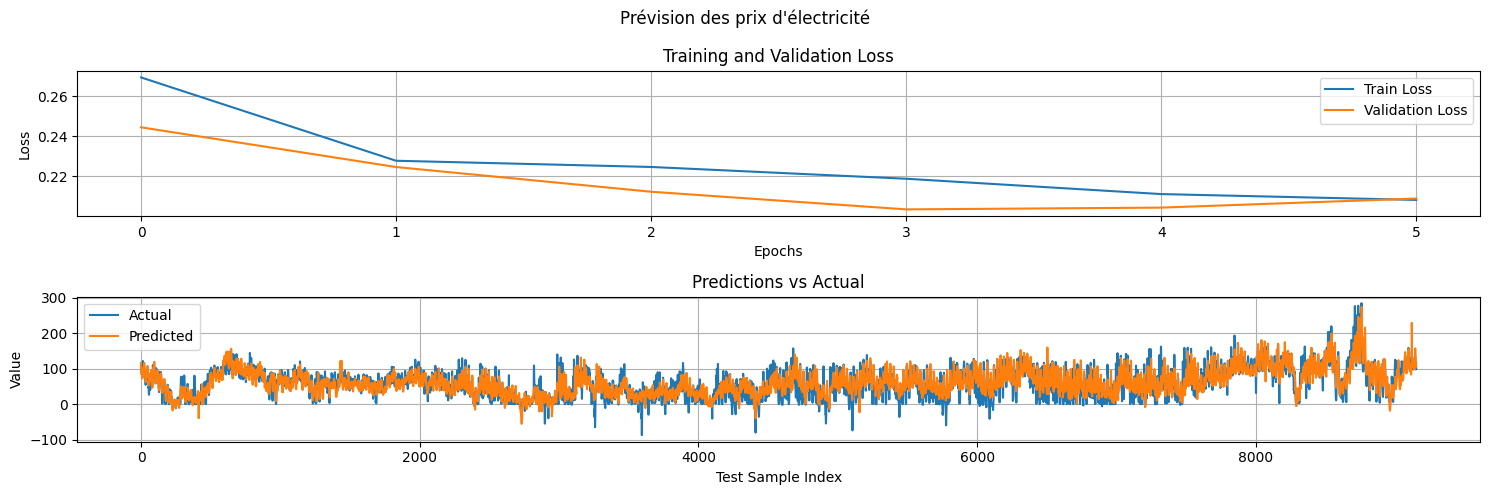

In [20]:
print("\nRésultats sur l'ensemble de test:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.6f}")
    
# Tracer les résultats
fig = plot_results(
    train_losses=train_losses,
    val_losses=val_losses,
    pred=preds_series,
    target=targets_series,
    title="Prévision des prix d'électricité"
)

plt.show()

In [2]:
import os
os.getcwd()

'/workspaces/ds_project_1/Energy_Forecasting/notebooks'

In [3]:
BASE_DIR = Path(os.getcwd()).resolve().parent
print(BASE_DIR)
os.chdir(str(BASE_DIR))

/workspaces/ds_project_1/Energy_Forecasting


In [4]:
os.getcwd()

'/workspaces/ds_project_1/Energy_Forecasting'

In [5]:
from energy_forecast.data.data_loaders import DataHelper

/workspaces/ds_project_1/Energy_Forecasting


In [6]:
data_helper = DataHelper()
train_loader, val_loader, test_loader = data_helper.get_data_loaders(seq_length=24, 
                                                                      forecasting_steps=1, 
                                                                      batch_size=32, 
                                                                      drop_last=True).values()

current working dir /workspaces/ds_project_1/Energy_Forecasting
current working dir /workspaces/ds_project_1/Energy_Forecasting
predictors shape: (9173, 15)
current working dir /workspaces/ds_project_1/Energy_Forecasting
predictors shape: (9173, 15)


In [8]:
data_helper.train_set.predictors.shape[1]

15

In [7]:
from energy_forecast.modeling.rnn import RNNForecasting
from energy_forecast.training.train import Trainer
from energy_forecast.modeling.losses import CustomLoss

loss_function = CustomLoss()

rnn = RNNForecasting(input_size=data_helper.train_set.predictors.shape[1],
                     hidden_size=64,
                     num_layers=1,
                     dropout=0.5,
                     output_size=1,
                     forecast_steps=1)

optimizer = torch.optim.Adam(params=rnn.parameters(), lr=1e-3)

trainer = Trainer(model=rnn,
                  loss_function=loss_function,
                  optimizer=optimizer)

trainer.fit(train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=1,
            patience=5)

epoch1/1: 100%|██████████| 1337/1337 [00:33<00:00, 40.38batch/s]


AttributeError: 'Trainer' object has no attribute 'loss_func'